#  Question 6 

In [1]:
from urllib.parse import urlparse
from shapely.geometry import Point
from geopandas.tools import sjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from requests import get
import contextily as ctx
import requests
import folium
from folium.plugins import MarkerCluster
import seaborn as sns

##  - Geographic distribution map -

In [2]:
# Read shapefile online
def cache_data(source_url, dest_dir):
    # 确保目标目录存在
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # 解析文件名
    filename = source_url.split('/')[-1].split('?')[0]  # 假设URL以文件名结尾
    file_path = os.path.join(dest_dir, filename)

    # 如果文件不存在，则下载
    if not os.path.isfile(file_path):
        response = requests.get(source_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            raise Exception(f"Failed to download {source_url}")

    return file_path

In [3]:
#读取london_Boroughshapefile
London_borough = gpd.read_file(
    cache_data('https://github.com/ZhengyongLiu/FSDS_GroupAssignment_Data/blob/main/Borough/London_Borough_Excluding_MHW.zip?raw=true', 
               os.path.join('data','geo')), driver='ESRI Shapefile')

#读取csv
url ='https://raw.githubusercontent.com/OnTheMon/FSDS-project/main/Data/cleaned_data_2023.csv'
df = pd.read_csv(url)
print(len(df))

37242


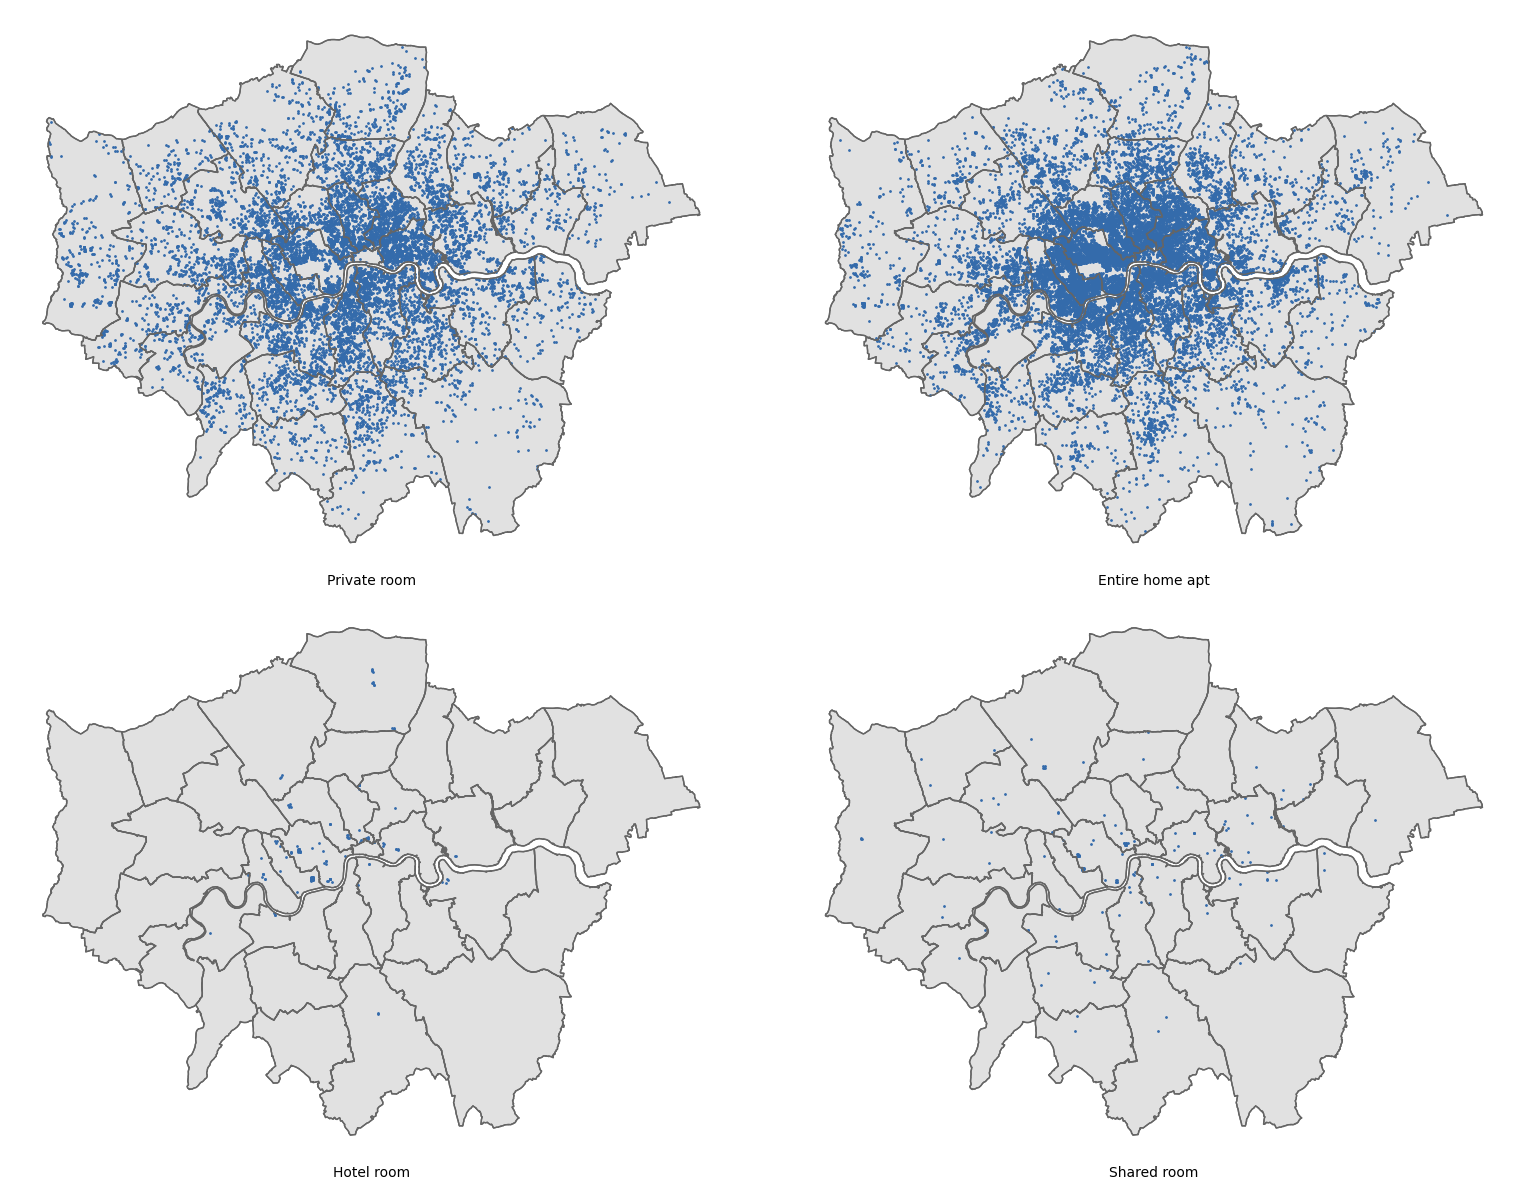

In [4]:
# Converting coordinates to geographic data and selecting the appropriate coordinate system
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
).to_crs(London_borough.crs)

# Determine the number of rows and columns of the subgraph
n_room_types = len(df["room_type"].unique())
n_cols = 2  
n_rows = n_room_types // n_cols + (n_room_types % n_cols > 0)

# Create a large enough graphical object
fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))

# Iterate over each room type and create a subgraph for each type
for k, room_type in enumerate(df["room_type"].unique()):
    idf = df[df["room_type"] == room_type]
    room_type_clean = room_type.replace("/", " ")

    # Determine the location of the current subgraph
    ax = axs[k // n_cols, k % n_cols]

    # Plotting data on the current subplot
    London_borough.plot(
        ax=ax, alpha=1, edgecolor="#656565", facecolor="#E1E1E1", linewidth=1
    )
    London_borough.plot(
        ax=ax, alpha=1, edgecolor="#656565", facecolor="none", linewidth=1, zorder=10
    )
    ax.scatter(idf.geometry.x, idf.geometry.y, c="#346BAB", s=1, alpha=1)

    # Setting subgraph styles
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(room_type_clean)


plt.tight_layout()
plt.savefig(r"Geographic_Distribution_Map.png", dpi=600)
plt.show()

## - Host type and number of listings - 

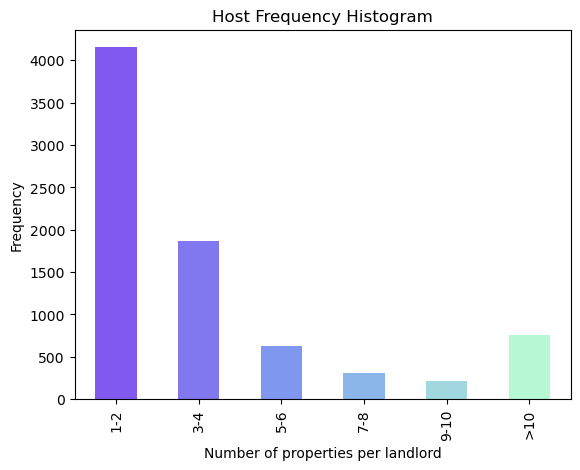

In [5]:
# 加载数据
# Host Name Frequency Histogram
host_name_counts = df['host_name'].value_counts()

# 将host_name_counts按照给定的分组进行处理
bins = [0, 2, 4, 6, 8, 10, float('inf')]
labels = ['1-2', '3-4', '5-6', '7-8', '9-10','>10']
grouped_counts = pd.cut(host_name_counts, bins=bins, labels=labels, right=False)

# 计算每个分组的频率
grouped_counts = grouped_counts.value_counts().sort_index()

# 画柱状图
colors = ['#835AF1', '#8178F0', '#8097EF', '#8AB6E9', '#A1D7DE', '#B8F7D4']  # 设置颜色
grouped_counts.plot(kind='bar', color=colors)

# 设置图表标题和标签
plt.title('Host Frequency Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of properties per landlord')

# 显示图表
plt.show()

## - Price distribution and competitiveness - 

<Axes: >

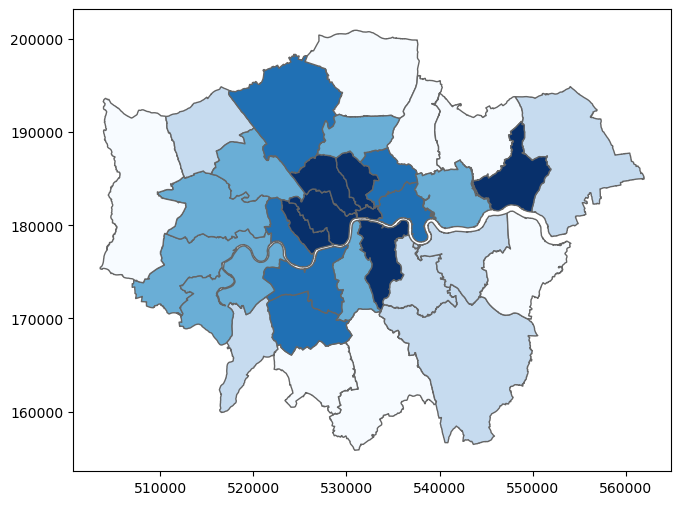

In [6]:
# 连接数据计算均值
joined = sjoin(df, London_borough, how='inner', predicate='within')

#清理数据（删除美元符号并转化为浮点数）
joined['price'] = joined['price'].replace('[\$,]', '', regex=True).astype(float)

#计算均值
meandf= joined.groupby('NAME')['price'].mean().reset_index()
gdf = London_borough.merge(meandf, on='NAME')


figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(1,1,1)
cmap = 'Blues'
gdf.plot(column='price',ax = ax,cmap = 'Blues',alpha = 1,edgecolor = '#656565', scheme='quantiles')

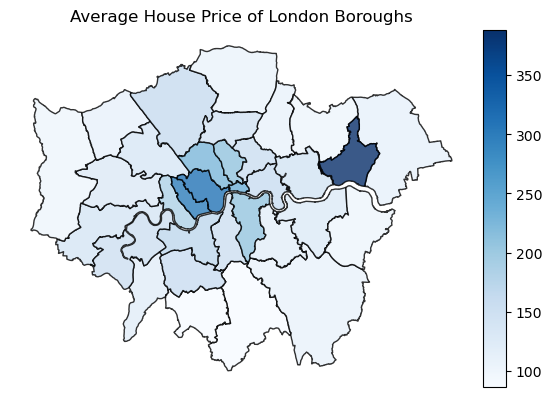

In [7]:
# 规范输出格式

# 设置颜色映射和归一化
cmap = 'Blues'
norm = mcolors.Normalize(vmin=gdf['price'].min(), vmax=gdf['price'].max())

# 创建图像和Axes对象
fig, ax = plt.subplots()

# 绘制GeoDataFrame
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='price', ax=ax, cmap=cmap, legend=True, cax=cax, alpha=0.8, edgecolor='k')

# 添加颜色带
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, cax=cax)

# 添加标题和注记
ax.set_title('Average House Price of London Boroughs')

# 隐藏坐标轴
ax.axis('off')

# 保存图像
plt.savefig(r'D:\HRX\CASA0013\foundations\Average House Price of London Boroughs.png', dpi=600)

# 显示图像
plt.show()